В данном ноутбуке я создам базовый класс, на основе которого обучу сверточную графовую нейронную сеть.

In [8]:
!pip install torch_geometric --quiet
!pip install nni --quiet

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

Импортируем необходимые библиотеки

In [9]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS,DBSCAN
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import jensenshannon

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split

from torch_geometric.utils import dense_to_sparse

from itertools import combinations

from multiprocessing import Pool, cpu_count

# Custom imports
import sys
sys.path.insert(1, "../input/dependecies")

from Graph import Graph
from GCN import (
    GCN,
    SimpleGCN,
    SimpleGAT,
    CustomDataset,
    train_model_accuracy,
    train_model_diversity,
    get_positive_and_negative
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Основные операция DARTS search space. Добавил 'none' для начальных вершин.

In [10]:

DARTS_OPS = [
        'none',
        'max_pool_3x3',
        'avg_pool_3x3',
        'skip_connect',
        'sep_conv_3x3',
        'sep_conv_5x5',
        'dil_conv_3x3',
        'dil_conv_5x5',
    ]

encoder = OneHotEncoder(handle_unknown='ignore')


Для графовой нейронной сети нам необходимо привести операции к числовому виду. Воспользуемся one-hot-encoder.

In [11]:
encoder = OneHotEncoder(handle_unknown='ignore')
ops_array = np.array(DARTS_OPS).reshape(-1, 1)

DARTS_OPS_ONE_HOT = encoder.fit_transform(ops_array).toarray()

print(DARTS_OPS_ONE_HOT)

[[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


Загрузим архитектуры обученных моделей, их предсказания и точность.

In [12]:
def load_json_from_directory(directory_path):
    """
    Обходит директорию и создает список словарей из JSON файлов.

    Аргументы:
        directory_path (str): Путь к директории, содержащей JSON файлы.

    Возвращает:
        list: Список словарей, загруженных из JSON файлов.
    """
    json_data = []
    for root, _, files in os.walk(directory_path):
        for file in tqdm(files):
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    try:
                        data = json.load(f)
                        json_data.append(data)
                    except json.JSONDecodeError as e:
                        print(f"Error decoding JSON from file {file_path}: {e}")
    return json_data

In [13]:
models_dict = load_json_from_directory('dataset_probs')

100%|██████████| 1000/1000 [01:10<00:00, 14.09it/s]


Посмотрю как распределена точность моделей

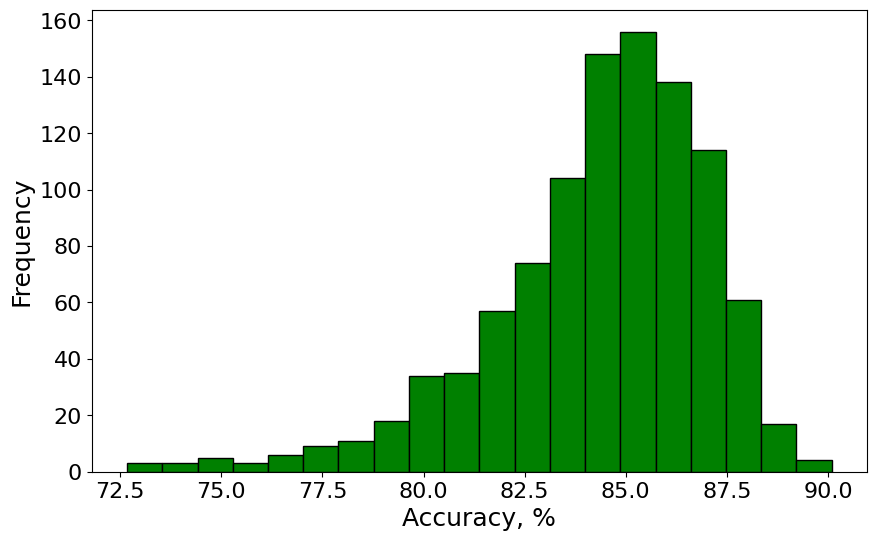

In [ ]:
accuracies = [model['test_accuracy'] for model in models_dict]

plt.figure(figsize=(10, 6))

plt.hist(accuracies, bins=20, edgecolor='black', color="green", weights=[1/len(accuracies)]*len(accuracies))
# plt.title('Distribution of Model Accuracies')
plt.xlabel('Accuracy', fontsize=18)
plt.ylabel('Percentage', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [15]:
graph = Graph(models_dict[1])

Посмотрю как выглядит граф.

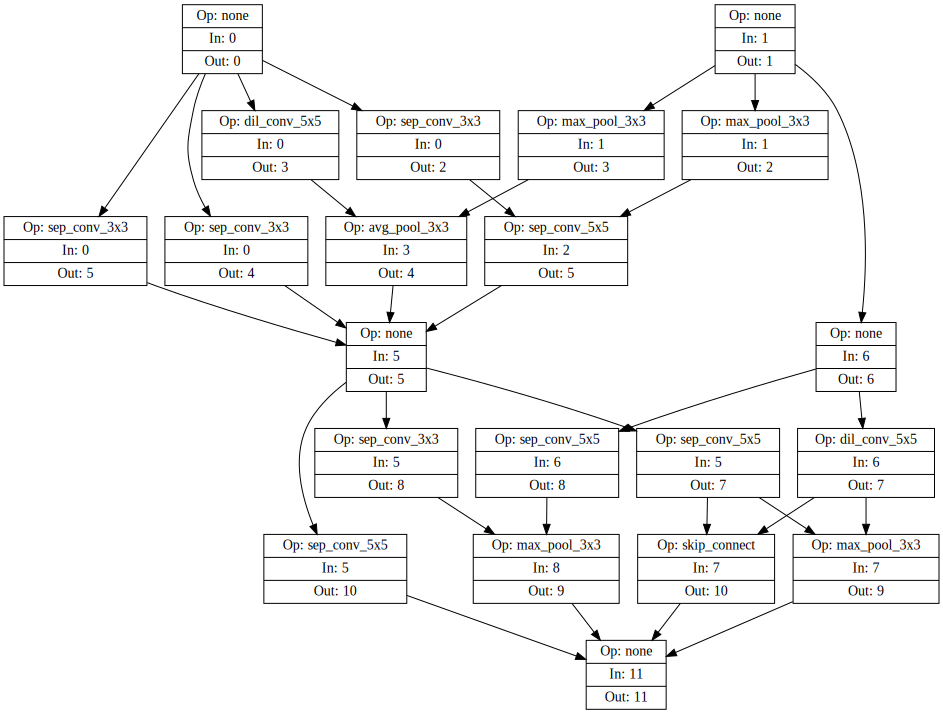

In [16]:
graph.show_graph()

In [17]:
graph.get_adjacency_matrix()

(array([[0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,


In [18]:
graph._normal_graph

[Op: none | In: 0 | Out: 0,
 Op: sep_conv_3x3 | In: 0 | Out: 2,
 Op: dil_conv_5x5 | In: 0 | Out: 3,
 Op: sep_conv_3x3 | In: 0 | Out: 4,
 Op: sep_conv_3x3 | In: 0 | Out: 5,
 Op: none | In: 1 | Out: 1,
 Op: max_pool_3x3 | In: 1 | Out: 2,
 Op: max_pool_3x3 | In: 1 | Out: 3,
 Op: sep_conv_5x5 | In: 2 | Out: 5,
 Op: avg_pool_3x3 | In: 3 | Out: 4]

In [19]:
graph._reduction_graph


[Op: none | In: 0 | Out: 0,
 Op: sep_conv_5x5 | In: 0 | Out: 2,
 Op: sep_conv_3x3 | In: 0 | Out: 3,
 Op: sep_conv_5x5 | In: 0 | Out: 5,
 Op: none | In: 1 | Out: 1,
 Op: dil_conv_5x5 | In: 1 | Out: 2,
 Op: sep_conv_5x5 | In: 1 | Out: 3,
 Op: max_pool_3x3 | In: 2 | Out: 4,
 Op: skip_connect | In: 2 | Out: 5,
 Op: max_pool_3x3 | In: 3 | Out: 4]

Матрица смежности и описания узлов(сначала в виде строк, потом в виде one-hot векторов) представлены так

In [20]:
graph.get_adjacency_matrix()

(array([[0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,


Рассчитаю разнообразие наивно -- просто буду говорить каков процент совпадений ответов у моделей 

In [21]:
def get_diversity(args):
    i, j, model_i, model_j = args
    preds_i = np.array(model_i["test_predictions"])
    preds_j = np.array(model_j["test_predictions"])
    distance = np.mean(preds_i == preds_j)
    return (i, j, distance)

def get_diversity_using_jensen_shannon(args):
    i, j, model_i, model_j= args
    preds_i = np.array(model_i["test_predictions"])
    preds_j = np.array(model_j["test_predictions"])
    distance = np.mean([np.sqrt(jensenshannon(p1, p2)) for p1, p2 in zip(preds_i, preds_j)])
    return (i, j, distance)

Построю матрицу разнообразия

In [22]:
def get_diversity_matrix_naive(models_dict, num_samples=None):
    n_models = len(models_dict)
    diversity_matrix = np.eye(n_models)

    # Предобработка: обрезаем и кешируем предсказания
    cached_preds = {}
    for i in range(n_models):
        preds = np.array(models_dict[i]["test_predictions"])
        if num_samples is not None:
            preds = preds[:num_samples]
        cached_preds[i] = preds

    for i in tqdm(range(n_models), desc="Computing diversity matrix"):
        for j in range(i + 1, n_models):
            distance = np.mean(cached_preds[i] == cached_preds[j])
            diversity_matrix[i, j] = diversity_matrix[j, i] = distance

    return diversity_matrix

def get_diversity_matrix(models_dict, num_samples=2000):
    n_models = len(models_dict)
    diversity_matrix = np.eye(n_models)

    # Предобработка: обрезаем и кешируем предсказания
    cached_preds = {}
    for i in range(n_models):
        preds = np.array(models_dict[i]["test_predictions"])
        cached_preds[i] = preds

    for i in tqdm(range(n_models), desc="Computing diversity matrix"):
        for j in range(i + 1, n_models):
            distance = np.mean(np.sqrt(jensenshannon(cached_preds[i], cached_preds[j])))
            diversity_matrix[i, j] = distance
            diversity_matrix[j, i] = distance

    return diversity_matrix

In [23]:
diversity_matrix = get_diversity_matrix(models_dict)

Computing diversity matrix:   0%|          | 0/1000 [00:02<?, ?it/s]


KeyboardInterrupt: 

100%|██████████| 1000/1000 [00:00<00:00, 7406.07it/s]


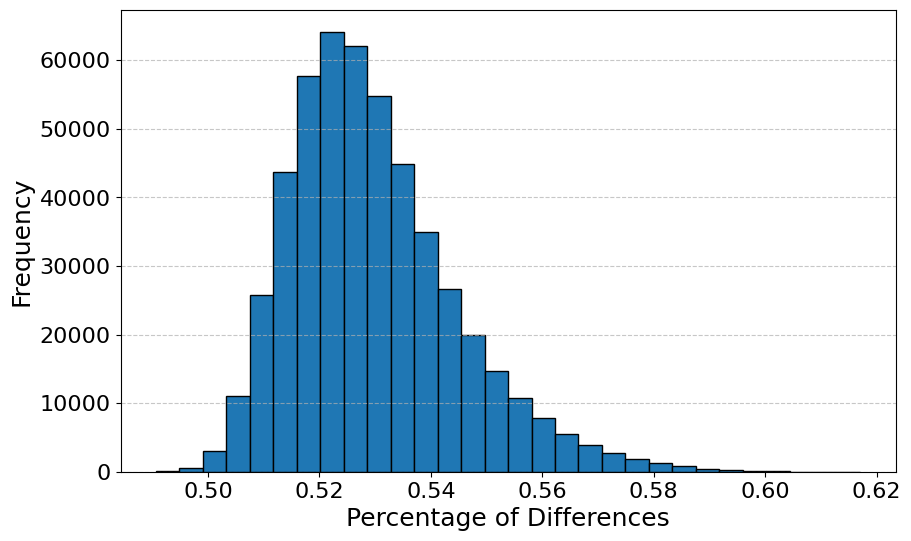

In [ ]:
diversities = []

for i in tqdm(range(len(models_dict))):
    for j in range(i + 1, len(models_dict)):
        diversities.append(diversity_matrix[i, j])
diversities = np.array(diversities)

plt.figure(figsize=(10, 6))

plt.hist(diversities, bins=30, edgecolor="black", weights=np.ones(len(diversities)) / len(diversities))
# plt.title("Distribution of Model Diversity")
plt.xlabel("Percentage of Differences", fontsize=18)
plt.ylabel("Percentage", fontsize=18)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Для triplet loss нам нужно будет подбирать positive и negative примеры, для этого удобно будет использовать дискретную матрицу разнообразия

В ней 1 -- positive, -1 -- negative, 0 в ином случае.

In [ ]:
def create_discrete_diversity_matrix(models_dict, diversity_matrix):
    discrete_diversity_matrix = np.zeros((len(models_dict), len(models_dict)))

    upper_margins = np.quantile(diversity_matrix, 0.9, axis=1)
    lower_margins = np.quantile(diversity_matrix, 0.1, axis=1)

    discrete_diversity_matrix[diversity_matrix > upper_margins[:, None]] = 1
    discrete_diversity_matrix[diversity_matrix < lower_margins[:, None]] = -1

    return discrete_diversity_matrix

In [ ]:
discrete_diversity_matrix = create_discrete_diversity_matrix(models_dict, diversity_matrix)

Строим тренировочный и валидационный датасеты.

In [ ]:
graphs = [Graph(model_dict, index=i) for (i, model_dict) in enumerate(models_dict)]
accuracies = [model['test_accuracy'] for model in models_dict]
graphs_dataset = CustomDataset(graphs, accuracies)

train_size = int(0.8 * len(graphs_dataset))  # 80% для тренировки
valid_size = len(graphs_dataset) - train_size  # Остальные 20% для теста

train_dataset, valid_dataset = random_split(graphs_dataset, [train_size, valid_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(valid_dataset)}")

100%|██████████| 1000/1000 [00:02<00:00, 428.62it/s]

Train dataset size: 800
Test dataset size: 200


In [ ]:
def extract_embeddings(model, dataset, device):
    model.to(device)
    model.eval()
    embeddings = []
    indices = []
    
    with torch.no_grad():
        for data in dataset:
            adj, features, index, _ = data
            
            # Перемещение данных на GPU (если используется)
            adj = adj.to(device)
            features = features.to(device)

            # Преобразование матрицы смежности в edge_index
            edge_index, _ = dense_to_sparse(adj)

            # Получение эмбеддинга графа
            embedding = model(features, edge_index)

            embeddings.append(embedding.cpu().numpy())
            indices.append(index)

    embeddings = np.vstack(embeddings)
    return embeddings, indices

Обучим модель предсказывать точность по архитектуре.

In [ ]:
input_dim = graphs_dataset[0][1].shape[1]
embedding_dim = 32
hidden_dim = 128  # Размерность скрытого слоя
output_dim = 1
num_epochs = 15

model_accuracy = GCN(input_dim, output_dim, dropout=0)
optimizer = torch.optim.AdamW(model_accuracy.parameters(), lr=1e-4)
criterion = nn.MSELoss()

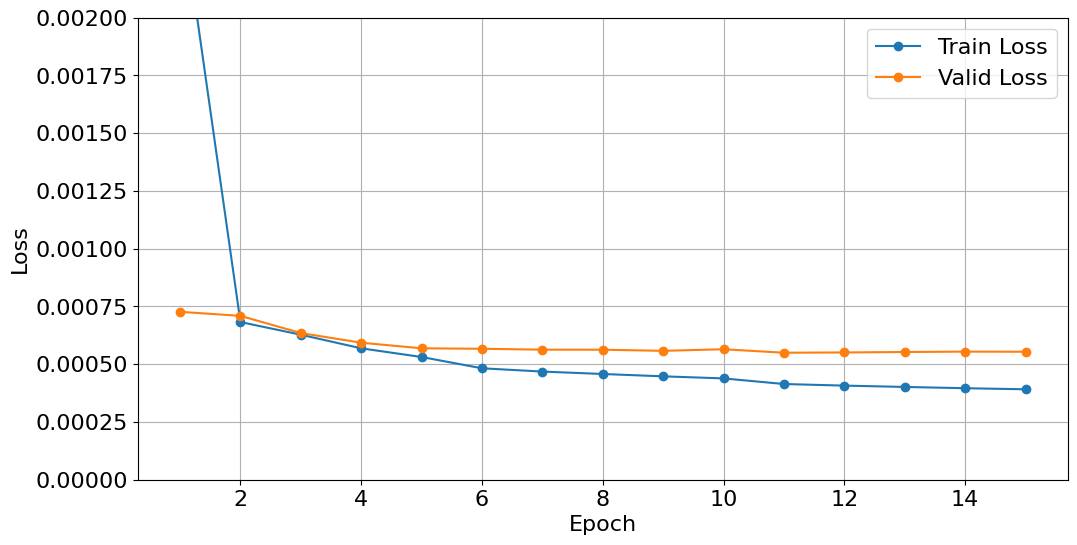

Training Progress: 100%|██████████| 15/15 [01:16<00:00,  5.08s/it]

Epoch 15, Train Loss: 0.0004, Valid Loss: 0.0006, LR: 0.000013


In [ ]:
train_model_accuracy(
    model_accuracy,
    train_dataset,
    valid_dataset,
    optimizer,
    criterion,
    num_epochs,
    device=device,
    developer_mode=False
);

In [ ]:
embeddings = extract_embeddings(model_accuracy, valid_dataset, device=device)[0]
for i, (adj, features, index, accuracy) in enumerate(valid_dataset):
    print(f"Index: {index:04d}, Accuracy: {accuracy.item():.3f}, Embedding: {embeddings[i][0]:.3f}")
    if i >= 20:
        break

Index: 0463, Accuracy: 0.802, Embedding: 0.860
Index: 0599, Accuracy: 0.858, Embedding: 0.861
Index: 0010, Accuracy: 0.838, Embedding: 0.874
Index: 0552, Accuracy: 0.811, Embedding: 0.849
Index: 0670, Accuracy: 0.855, Embedding: 0.857
Index: 0142, Accuracy: 0.846, Embedding: 0.824
Index: 0367, Accuracy: 0.846, Embedding: 0.837
Index: 0441, Accuracy: 0.875, Embedding: 0.869
Index: 0168, Accuracy: 0.867, Embedding: 0.844
Index: 0564, Accuracy: 0.851, Embedding: 0.845
Index: 0927, Accuracy: 0.835, Embedding: 0.856
Index: 0159, Accuracy: 0.825, Embedding: 0.850
Index: 0076, Accuracy: 0.841, Embedding: 0.838
Index: 0641, Accuracy: 0.873, Embedding: 0.851
Index: 0309, Accuracy: 0.843, Embedding: 0.868
Index: 0329, Accuracy: 0.848, Embedding: 0.860
Index: 0216, Accuracy: 0.836, Embedding: 0.855
Index: 0826, Accuracy: 0.840, Embedding: 0.824
Index: 0721, Accuracy: 0.800, Embedding: 0.839
Index: 0956, Accuracy: 0.872, Embedding: 0.874
Index: 0184, Accuracy: 0.880, Embedding: 0.869


In [ ]:
def triplet_loss(anchor, positive, negative, margin=0.1):
    d_ap = (anchor - positive).pow(2).sum(-1)
    d_an = (anchor - negative).pow(2).sum(-1)
    
    loss = F.relu(d_ap - d_an + margin)
    return loss.mean()

In [ ]:
input_dim = graphs_dataset[0][1].shape[1]
hidden_dim = 256  # Размерность скрытого слоя
output_dim = 16
num_epochs = 30

model = GCN(input_dim, output_dim, dropout=0)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = lambda anchor, positive, negative: triplet_loss(anchor, positive, negative, margin=1)

Основной код обучения модели похожести.

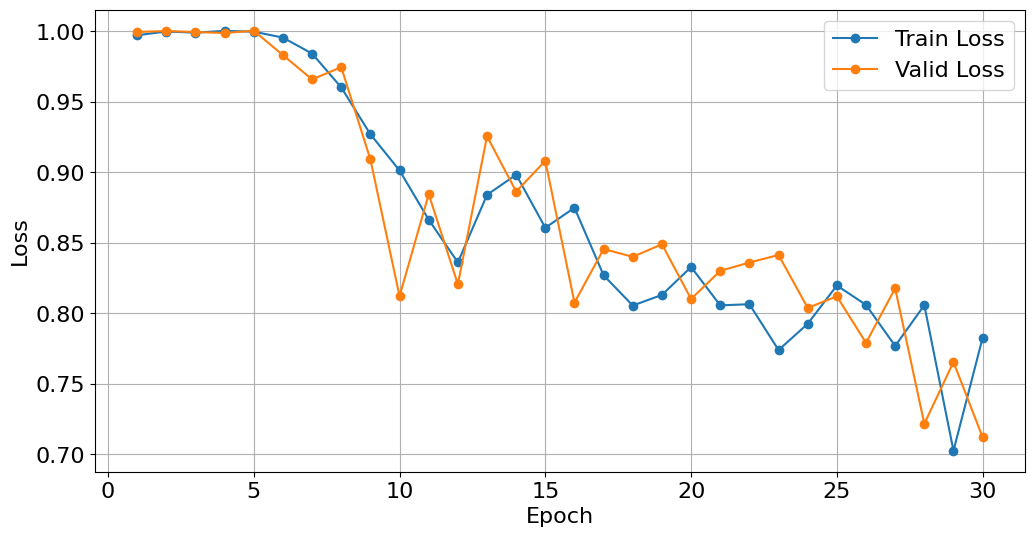

Training Progress: 100%|██████████| 30/30 [08:36<00:00, 17.21s/it]

Epoch 30, Train Loss: 0.7827, Valid Loss: 0.7121, LR: 0.000016


In [ ]:
train_model_diversity(
    model,
    train_dataset,
    valid_dataset,
    discrete_diversity_matrix,
    optimizer,
    criterion,
    num_epochs,
    device=device,
    developer_mode=False,
);

In [ ]:
def visualize_clusters(model, train_dataset, device="cpu", min_samples=3, eps=0.025):
    # Извлечение эмбеддингов
    embeddings, indices = extract_embeddings(model, train_dataset, device=device)
    
    # Преобразование эмбеддингов в 2D с помощью PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    
    # Кластеризация с помощью OPTICS
    # optics = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size, metric="euclidean")
    # clusters = optics.fit_predict(embeddings)
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=-1)
    clusters = dbscan.fit_predict(embeddings)
    
    # Визуализация кластеров
    plt.figure(figsize=(8, 6.5))
    scatter = plt.scatter(
        embeddings_2d[:, 0], 
        embeddings_2d[:, 1], 
        c=clusters, 
        cmap='tab10',  
        s=np.where(clusters == -1, 20, 70),  
        alpha=np.where(clusters == -1, 0.5, 1)
    )
    plt.xlabel("PCA Component 1", fontsize=16)
    plt.ylabel("PCA Component 2", fontsize=16)
    
    # Создание легенды для кластеров
    unique_clusters = np.unique(clusters)
    for cluster in unique_clusters:
        if cluster == -1:
          label = "Noise"
        else:
          label = f"Cluster {cluster}"
        plt.scatter([], [], color=scatter.cmap(scatter.norm(cluster)), label=label ,  s=50 if cluster != -1 else 20)
    
    plt.gca().set_facecolor('lightgrey')
    # plt.legend()
    plt.show()
    
    return clusters

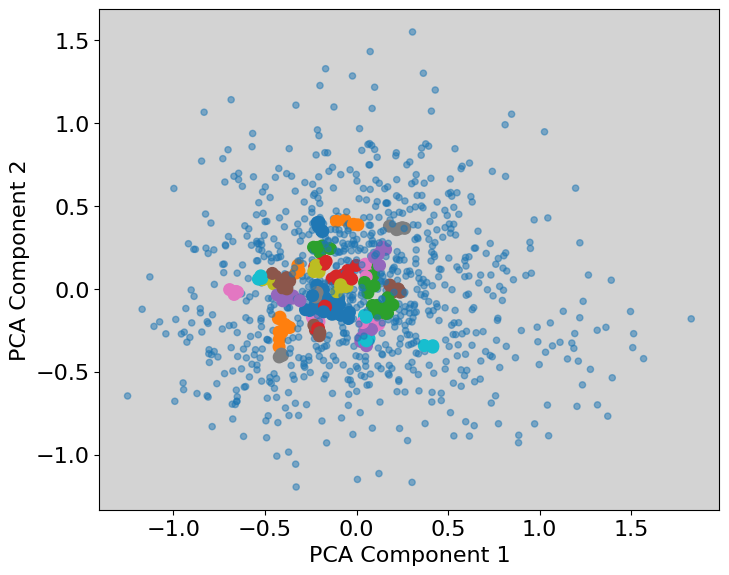

In [ ]:
clusters = visualize_clusters(
  model,
  graphs_dataset,
  device=device,
  min_samples=3,
  eps=0.075,
)

In [ ]:
embeddings[0]

array([0.8599067], dtype=float32)

In [ ]:
def compute_correlation(models_dict, dataset, model, diversity_matrix, device="cpu"):
    model.to(device)
    model.eval()

    N = len(dataset)
    embeddings = []

    with torch.no_grad():
        for adj, features, index, _ in dataset:
            adj, features = adj.to(device), features.to(device)

            edge_index, _ = dense_to_sparse(adj)

            embedding = model(features, edge_index).cpu().numpy()
            embeddings.append(embedding)

    embeddings = np.array(embeddings)

    distance_matrix = cdist(embeddings, embeddings, metric="euclidean")

    architectures = [models_dict[index] for index in dataset.indices]

    similarity_matrix = np.zeros((N, N))
    for i in tqdm(range(N), desc="Computing similarity matrix"):
        for j in range(i + 1, N):
            arch_i_index = dataset[i][2]
            arch_j_index = dataset[j][2]
            
            similarity_matrix[i, j] = diversity_matrix[arch_i_index, arch_j_index]
            similarity_matrix[j, i] = similarity_matrix[i, j]

    triu_indices = np.triu_indices(N, k=1)

    similarity_values = similarity_matrix[triu_indices]
    embedding_distances = distance_matrix[triu_indices]

    correlation_pearson, _ = pearsonr(embedding_distances, similarity_values)
    correlation_spearman, _ = spearmanr(embedding_distances, similarity_values)
    return correlation_pearson, correlation_spearman

Рассчитаю корреляции

In [ ]:
pearson_correlation, spearman_correlation = compute_correlation(models_dict, valid_dataset, model, diversity_matrix, device=device)

print(f"Корреляция Пирсона: {pearson_correlation:.3f}")
print(f"Корреляция Спирмена: {spearman_correlation:.3f}")

Computing similarity matrix: 100%|██████████| 200/200 [00:00<00:00, 1648.45it/s]

Корреляция Пирсона: -0.233
Корреляция Спирмена: -0.214


In [ ]:
def compute_cluster_mean_diversities(
    clusters: np.ndarray,
    diversity_matrix: np.ndarray,
    discrete_diversity_matrix: np.ndarray,
    min_samples: int = 10,
):
    """
    Для каждого кластера берёт «якорную» архитектуру (первый элемент кластера),
    затем в min_samples раз выбирает положительную и отрицательную архитектуры
    через get_positive_and_negative (по discrete_diversity_matrix),
    и усредняет заранее посчитанные отношения разнообразия из diversity_matrix.
    """
    n_clusters = len(set(clusters))
    
    for i in range(n_clusters):
        # индексы объектов, попавших в кластер i
        cluster_idxs = np.where(clusters == i)[0]
        if len(cluster_idxs) < 2:
            print(f"Cluster {i}: not enough samples.")
            continue
        
        anchor = cluster_idxs[0]
        pos_divs, neg_divs = [], []
        
        for _ in range(min_samples):
            positive, negative = get_positive_and_negative(discrete_diversity_matrix, anchor)
            if positive is None or negative is None:
                # пропускаем, если не удалось найти пару
                continue
            
            # вместо вызова get_diversity_js просто берём готовое значение
            pos_divs.append(diversity_matrix[anchor, positive])
            neg_divs.append(diversity_matrix[anchor, negative])
        
        mean_pos = np.mean(pos_divs) if pos_divs else None
        mean_neg = np.mean(neg_divs) if neg_divs else None
        
        print(f"Cluster {i}:")
        if mean_pos is not None:
            print(f"  Mean Positive Diversity: {mean_pos:.4f}")
        else:
            print("  No positive diversity data available.")
        
        if mean_neg is not None:
            print(f"  Mean Negative Diversity: {mean_neg:.4f}")
        else:
            print("  No negative diversity data available.")
        
        # ограничиваем вывод первыми 11 кластерами
        if i >= 10:
            break
            
compute_cluster_mean_diversities(
    clusters,
    diversity_matrix,
    discrete_diversity_matrix,
    min_samples=10,
)

Cluster 0:
  Mean Positive Diversity: 0.5520
  Mean Negative Diversity: 0.5017
Cluster 1:
  Mean Positive Diversity: 0.5778
  Mean Negative Diversity: 0.5383
Cluster 2:
  Mean Positive Diversity: 0.5467
  Mean Negative Diversity: 0.5138
Cluster 3:
  Mean Positive Diversity: 0.5618
  Mean Negative Diversity: 0.5191
Cluster 4:
  Mean Positive Diversity: 0.5549
  Mean Negative Diversity: 0.5158
Cluster 5:
  Mean Positive Diversity: 0.5545
  Mean Negative Diversity: 0.5015
Cluster 6:
  Mean Positive Diversity: 0.5585
  Mean Negative Diversity: 0.5231
Cluster 7:
  Mean Positive Diversity: 0.5458
  Mean Negative Diversity: 0.5096
Cluster 8:
  Mean Positive Diversity: 0.5531
  Mean Negative Diversity: 0.5099
Cluster 9:
  Mean Positive Diversity: 0.5442
  Mean Negative Diversity: 0.5065
Cluster 10:
  Mean Positive Diversity: 0.5654
  Mean Negative Diversity: 0.5191


In [ ]:
# Индексы кластеров
cluster_1_indexes = np.where(clusters == 1)[0]
cluster_2_indexes = np.where(clusters == 2)[0]

# ====== Средняя похожесть внутри первого кластера ======
n1 = len(cluster_1_indexes)
if n1 > 1:
    # Выбираем подматрицу diversity_matrix для кластер 1
    submat_1 = diversity_matrix[np.ix_(cluster_1_indexes, cluster_1_indexes)]
    # Берём только верхний треугольник без диагонали
    triu_i, triu_j = np.triu_indices(n1, k=1)
    sims_within_1 = submat_1[triu_i, triu_j]
    mean_similarity_within_cluster_1 = np.mean(sims_within_1)
else:
    mean_similarity_within_cluster_1 = None

# ====== Средняя похожесть между кластерами 1 и 2 ======
if len(cluster_1_indexes) > 0 and len(cluster_2_indexes) > 0:
    sims_between = diversity_matrix[np.ix_(cluster_1_indexes, cluster_2_indexes)]
    mean_similarity_between_clusters = np.mean(sims_between)
else:
    mean_similarity_between_clusters = None

# ====== Результаты ======
if mean_similarity_within_cluster_1 is not None:
    print(f"Средняя похожесть внутри первого кластера: {mean_similarity_within_cluster_1:.4f}")
else:
    print("В первом кластере недостаточно элементов для расчёта похожести.")

if mean_similarity_between_clusters is not None:
    print(f"Средняя похожесть между первым и вторым кластерами: {mean_similarity_between_clusters:.4f}")
else:
    print("Недостаточно элементов в одном из кластеров для расчёта межкластерной похожести.")

Средняя похожесть внутри первого кластера: 0.5483
Средняя похожесть между первым и вторым кластерами: 0.5355


In [ ]:
with open("logs.txt", "w", encoding="utf-8") as log:
    for index in cluster_1_indexes:
        tmp_graph = Graph(models_dict[index], index=index)
        for key, value in models_dict[index]["architecture"].items():
            log.write(f"{key}: {value}\n")
        log.write("\n")  # Добавляем пустую строку между архитектурами

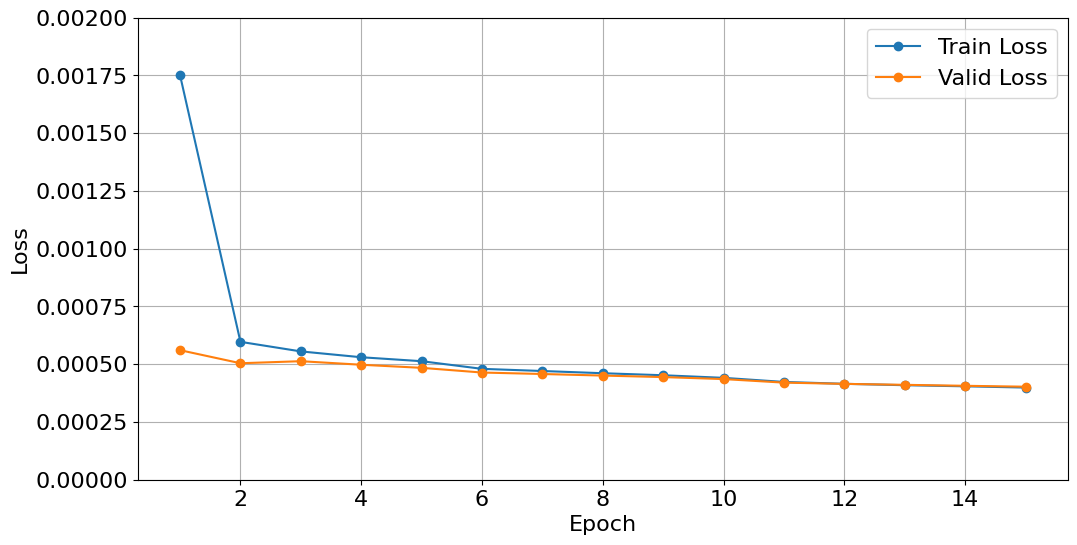

Training Progress: 100%|██████████| 15/15 [01:30<00:00,  6.04s/it]

Epoch 15, Train Loss: 0.0004, Valid Loss: 0.0004, LR: 0.000013


In [ ]:
input_dim = graphs_dataset[0][1].shape[1]
embedding_dim = 32
hidden_dim = 128  # Размерность скрытого слоя
output_dim = 1
num_epochs = 15

model_accuracy = GCN(input_dim, output_dim, dropout=0)
optimizer = torch.optim.AdamW(model_accuracy.parameters(), lr=1e-4)
criterion = nn.MSELoss()

train_model_accuracy(
    model_accuracy,
    graphs_dataset,
    valid_dataset,
    optimizer,
    criterion,
    num_epochs,
    device=device,
    developer_mode=False
);

In [ ]:
train_size = int(0.99 * len(graphs_dataset))  # 80% для тренировки
valid_size = len(graphs_dataset) - train_size  # Остальные 20% для теста

train_dataset, valid_dataset = random_split(graphs_dataset, [train_size, valid_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(valid_dataset)}")

Train dataset size: 990
Test dataset size: 10


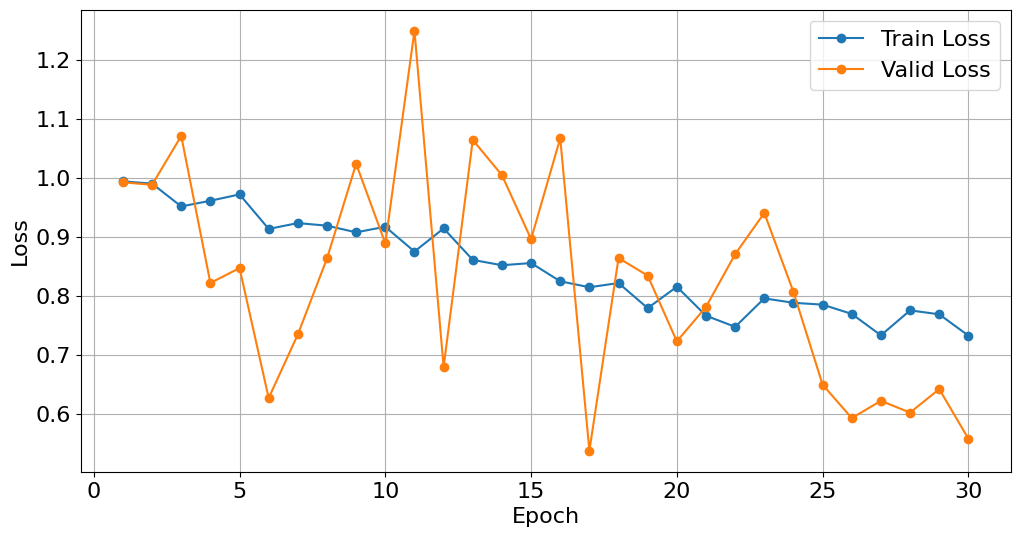

Training Progress: 100%|██████████| 30/30 [09:07<00:00, 18.25s/it]

Epoch 30, Train Loss: 0.7323, Valid Loss: 0.5576, LR: 0.000016


In [ ]:
input_dim = graphs_dataset[0][1].shape[1]
hidden_dim = 256  # Размерность скрытого слоя
output_dim = 16
num_epochs = 30

model = GCN(input_dim, output_dim, dropout=0)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = lambda anchor, positive, negative: triplet_loss(anchor, positive, negative, margin=1)
train_model_diversity(
    model,
    train_dataset,
    valid_dataset,
    discrete_diversity_matrix,
    optimizer,
    criterion,
    num_epochs,
    device=device,
    developer_mode=False,
);

In [ ]:
torch.save(model.state_dict(), "model_diversity_weights.pth")
torch.save(model_accuracy.state_dict(), "model_accuracy_weights.pth")

In [ ]:
!zip weights model_diversity_weights.pth model_accuracy_weights.pth

  adding: model_diversity_weights.pth (deflated 8%)
  adding: model_accuracy_weights.pth (deflated 9%)
